This Notebook contains the solution to the Assignment shared

Author: Utkarsh Desai

Only the next cell needs an update, the rest of the notebook can be executed as is.

## Required
Provide the OpenAI API Key and the Path to the input file with feedbacks below. The file is not included with the code

In [1]:
OPENAI_KEY = ""
INPUT_FILE = "spotify-reviews.csv"

## Imports

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from typing import List, Tuple
import collections
from IPython.display import display, Markdown

%matplotlib inline

## Data Loading and Cleaning

In [3]:
data = pd.read_csv(INPUT_FILE)

# For this analysis, we select only a subset of the columns which are considered useful
selected_data = data[['Source', 'CreatedAt', 'Content', 'metadata.Version', 'metadata.Score', 'metadata.Rating']]

In [4]:
# The data has two separate fields for rating, one each for app store and play store.
# Unify them so we only need to deal with a single field
selected_data['metadata.Rating'] = selected_data['metadata.Rating'].fillna(0)
selected_data['metadata.Score'] = selected_data['metadata.Score'].fillna(0)

# Creata a new field and drop the older ones
selected_data['RatingScore'] = selected_data['metadata.Rating'] + selected_data['metadata.Score']
selected_data = selected_data.drop(columns=['metadata.Rating' ,'metadata.Score'])


C:\Users\Utkarsh\AppData\Local\Temp\ipykernel_28568\3843335038.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['metadata.Rating'] = selected_data['metadata.Rating'].fillna(0)
C:\Users\Utkarsh\AppData\Local\Temp\ipykernel_28568\3843335038.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['metadata.Score'] = selected_data['metadata.Score'].fillna(0)
C:\Users\Utkarsh\AppData\Local\Temp\ipykernel_28568\3843335038.py:7: SettingWithCopyWarning: 
A value is trying to be set on a c

In [5]:
# Some more cleaning and processing
selected_data['metadata.Version'] = selected_data['metadata.Version'].fillna(0)
selected_data['CreatedAt'] = pd.to_datetime(selected_data['CreatedAt'])
selected_data['Month_Day'] = selected_data['CreatedAt'].dt.strftime('%m_%d')

## High level analysis
We conduct some basic analysis of the dataset to see if anything stands out. 

This might not always be informative, but can provide insights into the data in some cases.

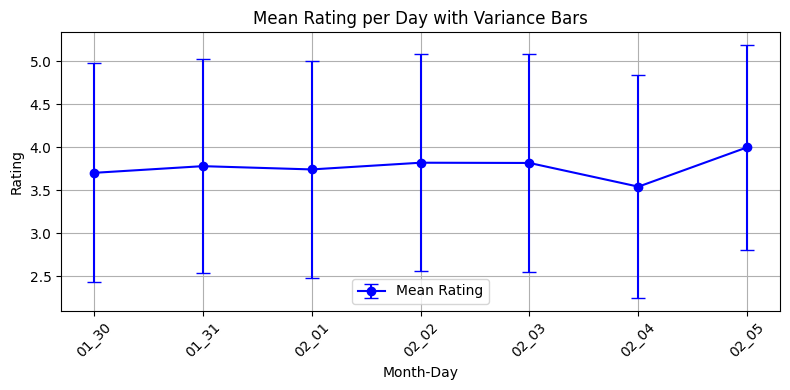

In [6]:
grouped = selected_data.groupby('Month_Day')['RatingScore'].agg(['mean', 'std']).reset_index()
plt.figure(figsize=(8, 4))
plt.errorbar(grouped['Month_Day'], grouped['mean'], yerr=grouped['std'].apply(lambda x: x**0.5), fmt='o', 
             capsize=5, linestyle='-', color='b', label='Mean Rating')
plt.xlabel('Month-Day')
plt.ylabel('Rating')
plt.title('Mean Rating per Day with Variance Bars')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

Here we can see there is small drop in average ratings on 02/04. Might be worthwhile to see if something happened on that day.

Lets do a similar analysis on the App version instead of the feedback date.

In [7]:
grouped_by_ver = selected_data.groupby('metadata.Version')['RatingScore'].agg(['mean', 'std', np.count_nonzero]).reset_index()
grouped_by_ver

,metadata.Version,mean,std,count_nonzero
0,0,3.750000,1.500000,4
1,8.6.26.897,1.000000,NaN,1
2,8.7.66.534,1.000000,NaN,1
3,8.9.46.426,1.000000,NaN,1
4,8.9.58.572,1.000000,NaN,1
5,8.9.8,5.000000,NaN,1
6,8.9.8.545,3.000000,NaN,1
7,9.0.10.415,5.000000,NaN,1
8,9.0.12.567,1.000000,0.000000,4
9,9.0.14,3.764748,1.593920,2763


Casually looking at the data, we can see all ratings for the version 9.0.12.567 are at 1-star. Also, 9.0.14.561 has a lower than usual mean rating

While there are only 4 (or 17) feedbacks, analysis like this can identify if users are facing issues with a particular App version

**Typically, we can also do a similar, high level analysis using word frequencies, identifying terms and phrases used often via statistical methods.**

**But since we are going to do a deeper analysis anyway, for now we will not do such a term frequency based analysis**

## Data Split
For what follows, we will need a sparate dataset with some manuallly annotated labels that we can use to judge the quality of model results.

Typically you can create a random subset of the dataset - or from a similar distribution - and keep that for evaluation

In this case, we have a small set of feedback from PlayStore and almost all feedback is from the AppStore.

So, to keep things simple, we use the PlayStore data as the evaluation set and the AppStore data for the rest of the analysis. Again, this is only for this specific case.

In [8]:
appstore_data = selected_data[selected_data['Source']=='Appstore']
playstore_data = selected_data[selected_data['Source']=='Playstore']
appstore_data.shape, playstore_data.shape

((2865, 6), (32, 6))

The PlayStore data is manually annotated to indicate whether the feedback is informative and about the App, or is noisy, vague or generic feedback.

The annotated file is provided and we will be using it here.

In [9]:
labeled_data = pd.read_csv("labeled_data.csv", encoding="cp1252")

## LLM based Analysis

We now initialize the OpenAI client and perform deeper analysis using the LLM models

In [10]:
from openai import OpenAI
from model_wrappers import OpenAILLM, OpenAIEmbedding
import utils
import prompt_collection as pmpt

In [11]:
client = OpenAI(api_key=OPENAI_KEY)
llm = OpenAILLM(client, model='gpt-4o-mini')

### Identifying Informative Feedback

Since we do not have any annotations that help us identify which feedbacks are useful, we can use an LLM to help us here.

We prompt an LLM to classfiy the feedeback for us and use the labels for the rest of the pipeline, discarding feedback that is not informative.

**But before that, lets establish a baseline and see how well the prompt and the LLM are able to generate the correct labels. We use the manually annotated dataset for this.**

In [12]:
# From the labeled dataset, extract all feedback, join it together and prepare an input for the LLM
joined_labeled_feedback = utils.process_batch(
    input_feedbacks=labeled_data['Content'],
    add_idx=True
)

# prepare a message structure for calling the LLM
benchmark_messages = utils.prep_messages(pmpt.info_system_prompt, joined_labeled_feedback)

# Call the LLM
benchmark_response = llm.call(benchmark_messages)

In [13]:
# Extract the predictions from the LLM output
benchmark_predictions = utils.clean_info_response(benchmark_response)

In [14]:
# Compute some basic metrics on how well the LLM is able to classify the data
from sklearn.metrics import confusion_matrix, accuracy_score
print("Accuracy:", accuracy_score(labeled_data['Informative'], benchmark_predictions))
print("\nConfusion Matrix:")
confusion_matrix(labeled_data['Informative'], benchmark_predictions),  

Accuracy: 0.84375

Confusion Matrix:


(array([[ 7,  1],
        [ 4, 20]], dtype=int64),)

**Now that we have baseline performance measure for this method, we can now classify all the feedback (AppStore)**

In [15]:
# classify all feedback (takes about 4 min)
all_ratings = []
all_content = appstore_data['Content']

LLM_INPUT_BATCH_LENGTH = 100

for i in range(0, len(all_content), LLM_INPUT_BATCH_LENGTH):
    input_batch = all_content[i:i + LLM_INPUT_BATCH_LENGTH]
    llm_input = utils.process_batch(
        input_feedbacks=input_batch,
        add_idx=True
    )
    batch_messages = utils.prep_messages(pmpt.info_system_prompt, llm_input) 
    batch_response = llm.call(batch_messages)
    batch_predictions = utils.clean_info_response(batch_response)
    if len(batch_predictions) != len(input_batch):
        print("Mismatch in Input/Output detected")
    all_ratings.extend(batch_predictions)
    print(i, len(input_batch), len(batch_predictions))

0 100 100
100 100 100
200 100 100
300 100 100
400 100 100
500 100 100
600 100 100
700 100 100
800 100 100
900 100 100
1000 100 100
1100 100 100
1200 100 100
1300 100 100
1400 100 100
1500 100 100
1600 100 100
1700 100 100
1800 100 100
1900 100 100
2000 100 100
2100 100 100
2200 100 100
2300 100 100
2400 100 100
2500 100 100
2600 100 100
2700 100 100
2800 65 65


In [16]:
# Update the dataset with the new labels
appstore_data['Informative'] = all_ratings

# Now that we have informative feedback, we will only work with those rows
informative_feedback = appstore_data[appstore_data['Informative']==1]

C:\Users\Utkarsh\AppData\Local\Temp\ipykernel_28568\1653953662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  appstore_data['Informative'] = all_ratings


We will now try to answer questions and extract insights based on the feedbacks available.

For complaint related questions, we will only analyze poor feedback (rating < 3)

One can always argue that complaints can be present in high rating feedback as well, but for this exercise we will go with this assumption to demonstrate the method.

In [17]:
poor_feedback = informative_feedback[informative_feedback['RatingScore']<3]
poor_feedback_inputs = utils.process_batch(poor_feedback['Content'], add_idx=False)
all_feedback_inputs = utils.process_batch(informative_feedback['Content'], add_idx=False)

#### Top Bugs

In [18]:
bugs_question = "###Question: based on the provided set of user feedback, what are the top 5 bugs reported by users? \n ###Feedback:\n"
bugs_prompt = pmpt.generic_qa_prompt + bugs_question + poor_feedback_inputs
bugs_message = utils.prep_messages(sys_prompt=None, message_content=bugs_prompt)
bugs_response = llm.call(bugs_message)
display(Markdown(bugs_response))

TypeError: prep_messages() got an unexpected keyword argument 'messages'

#### User Suggestions

In [ ]:
improvement_question = "###Question: based on the provided set of user feedback, what are the top 3 suggestions from users regarding *Ads*? \n ###Feedback:\n"
improvement_prompt = pmpt.generic_qa_prompt + improvement_question + all_feedback_inputs
improvement_message = utils.prep_messages(sys_prompt=None, messages=improvement_prompt)
improvement_response = llm.call(improvement_message)
display(Markdown(improvement_response))

#### Ads Issues

In [ ]:
adsissue_question = "###Question: based on the provided set of user feedback, what are the top 3 issues from users regarding Ads? \n ###Feedback:\n"
adsissue_prompt = pmpt.generic_qa_prompt + adsissue_question + poor_feedback_inputs
adsissue_message = utils.prep_messages(sys_prompt=None, messages=adsissue_prompt)
adsissue_response = llm.call(adsissue_message)
display(Markdown(adsissue_response))

#### Pricing 

In [ ]:
pricing_question =  "###Question: based on the provided set of user feedback, what are the users talking about the pricing of the service? \n ###Feedback:\n"
pricing_prompt = pmpt.generic_qa_prompt + pricing_question + all_feedback_inputs
pricing_message = utils.prep_messages(sys_prompt=None, messages=pricing_prompt)
pricing_response = llm.call(pricing_message)
display(Markdown(pricing_response))

## Additional Insights

The previous cells helped identify specific issues or answered particular questions about the feedback that users shared.

We can also analyze the feedback in an alternate, complimentary fashion to reveal new insights.

**We will project the feedback into an embedding space and then see if we can identify distinct clusters in this space**

In [ ]:
# Generate embeddings for all informative feedback
embed_model = OpenAIEmbedding(client)
embeddings = embed_model.get_embeddings(informative_feedback['Content'])

In [ ]:
# Lets try to find 10 clusters
labels = utils.cluster_documents_kmeans(embeddings, 10)

In [ ]:
documents_list  = list(informative_feedback['Content'])
clusters = collections.defaultdict(list)
for idx, label in enumerate(labels):
    clusters[label].append(documents_list[idx])  # Store document in the cluster

In [ ]:
def summarize_cluster(documents):
    prompt_input_docs = utils.process_batch(documents)
    summ_prompt = pmpt.cluster_summ_prompt + prompt_input_docs
    summ_message = utils.prep_messages(sys_prompt=None, messages=summ_prompt)
    summ_response = llm.call(summ_message)
    return summ_response

For each cluster, lets not generate a 1-2 word desctiption and a 1-line summary

In [ ]:
summaries = {}

for k in clusters.keys():
    docs = clusters[k]
    summary = summarize_cluster(docs)
    summaries[k] = summary

summaries

As we can see, each cluster captures a particular theme. Although, feedback regarding Ads or Pricing seems to be prevanlent everywhere.